# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from scipy.optimize import minimize

In [3]:
# Considering two portfolios, one with high volatility (Risk) and one with low volatility (Risk), while making sure they both are profitable.

# Low volatility stocks - Usually things of daily usage and need.
tickers_low = ['MA', 'COST', 'BKNG', 'LLY', 'UBER'] 

# High volatility stocks - Usually tech stocks and stocks within the same sector.
tickers_high = ['MSFT', 'NFLX', 'NVDA', 'CSCO', 'META']

# Focusing on two years of data
start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock_low = yf.download(tickers_low, start = start_date, end = end_date)
stock_high = yf.download(tickers_high, start = start_date, end = end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [4]:
#Create a dataframe of daily returns
daily_returns_low = np.log(stock_low['Close']/stock_low['Close'].shift(1))
daily_returns_low = daily_returns_low.dropna()
daily_returns_high = np.log(stock_high['Close']/stock_high['Close'].shift(1))
daily_returns_high = daily_returns_high.dropna()

#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility_low = {ticker: np.std(daily_returns_low[ticker])*np.sqrt(252) for ticker in tickers_low}
annualized_volatility_high = {ticker: np.std(daily_returns_high[ticker])*np.sqrt(252) for ticker in tickers_high}


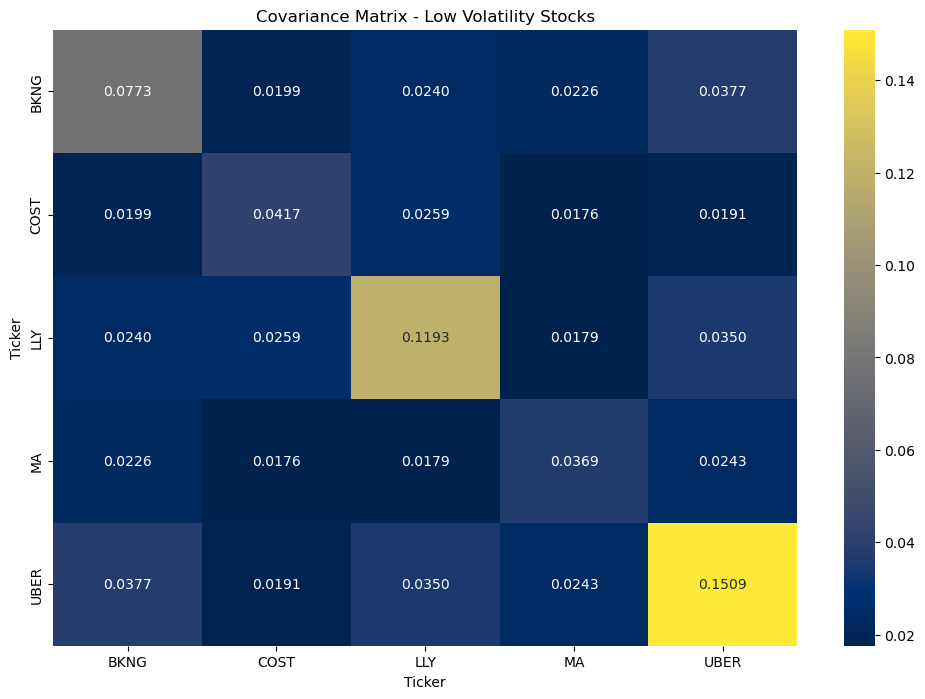

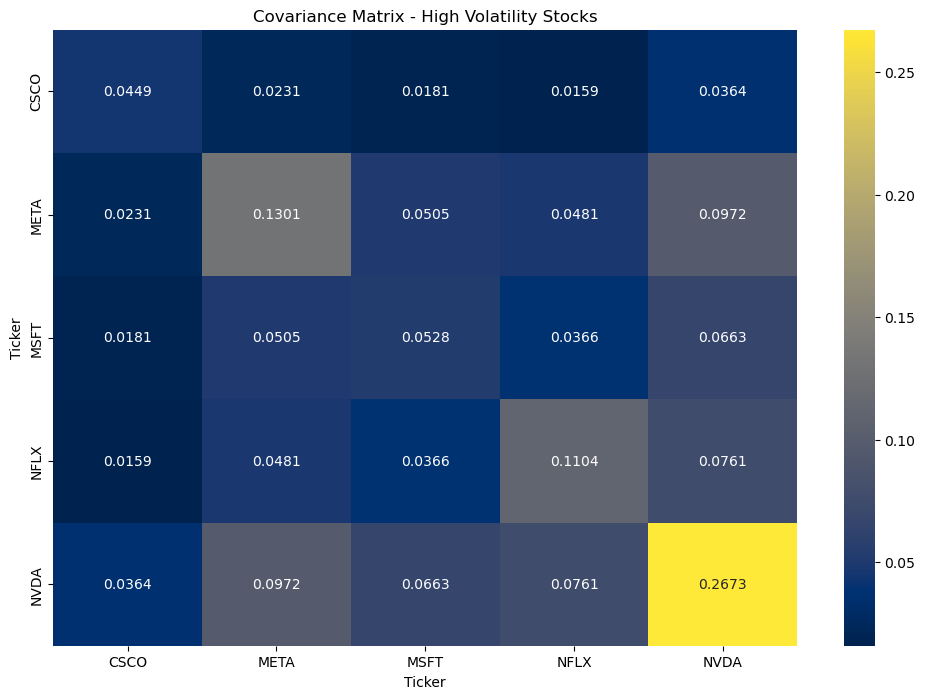

In [5]:
# Calculate the covariance matrix
covariance_matrix_low = 252*((daily_returns_low).cov())
covariance_matrix_high = 252*((daily_returns_high).cov())

# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix_low, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix - Low Volatility Stocks')
plt.show()

plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix_high, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix - High Volatility Stocks')
plt.show()

In [6]:
# Checking the annualized volatility of the portfolios
daily_returns_high.var() * 252

Ticker
CSCO    0.044920
META    0.130087
MSFT    0.052772
NFLX    0.110443
NVDA    0.267294
dtype: float64

In [7]:
### The variance seems resonable for both portfolios, except for those cases where there was known to be a huge jump in price (AI boom).
### There dose not seem to be any correlation between the two portfolios, which is good for diversification.

In [8]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, subject to the following investment constraints
#1) Must invest at least 20% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

### I will keep these conditions to enusre fair diversification.
### We focus here on minimumizing the portfolio volatility to ensure that the portfolio is less risky, while still being profitable.

# Number of assets
n_assets_low = len(tickers_low)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets_low] * n_assets_low)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
             {'type': 'ineq', 'fun': lambda weights: min(weights)-.20},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix_low, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers_low, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
MA: Weight = 0.2000
COST: Weight = 0.2000
BKNG: Weight = 0.2000
LLY: Weight = 0.2000
UBER: Weight = 0.2000


In [9]:
### Equally balanced, not a surprise since we are minimizing volatility and they all have quite similar returns.

In [10]:
print(f' The optimal volatility subject to the constraints is {result.fun*100:.2f}%')
print(f' The expected Two-year return of the portfolio is {np.sum(optimal_weights * (stock_low['Close'].iloc[-1]-stock_low['Close'].iloc[0])/stock_low['Close'].iloc[0])*100:.2f}%')

 The optimal volatility subject to the constraints is 19.12%
 The expected Two-year return of the portfolio is 80.32%


In [11]:
# Doing the same for the high volatility stocks - We are aiming here to maximize return mainly.

#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, subject to the following investment constraints
#1) Must invest at least 20% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

### I will keep these conditions to enusre fair diversification.
### We focus here on maximizing the profit regardless of the volatility.

# Number of assets
n_assets_high = len(tickers_high)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets_high] * n_assets_high)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 20% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.20},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to maximize portfolio returns
def portfolio_returns(weights):
    portfolio_returns = np.dot(daily_returns_high.mean(), weights) # Two-year expected return
    # Notice that these values are negative, since we are taking the log returns.
    # We want to maximize returns, so we use these negative values for minimization.
    return portfolio_returns

# Run the optimization to find the optimal weights
result = minimize(portfolio_returns, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to maximize returns:")
for ticker, weight in zip(tickers_high, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to maximize returns:
MSFT: Weight = 0.1997
NFLX: Weight = 0.2002
NVDA: Weight = 0.1997
CSCO: Weight = 0.1997
META: Weight = 0.2006


In [12]:
print(f' The expected volatility subject to the constraints is {np.sum(optimal_weights * daily_returns_high.std().values * np.sqrt(252) * 100):.2f}%')
print(f' The expected Two-year return of the portfolio is {np.sum(optimal_weights * (stock_high['Close'].iloc[-1]-stock_high['Close'].iloc[0])/stock_high['Close'].iloc[0])*100:.2f}%')

 The expected volatility subject to the constraints is 33.05%
 The expected Two-year return of the portfolio is 129.57%
